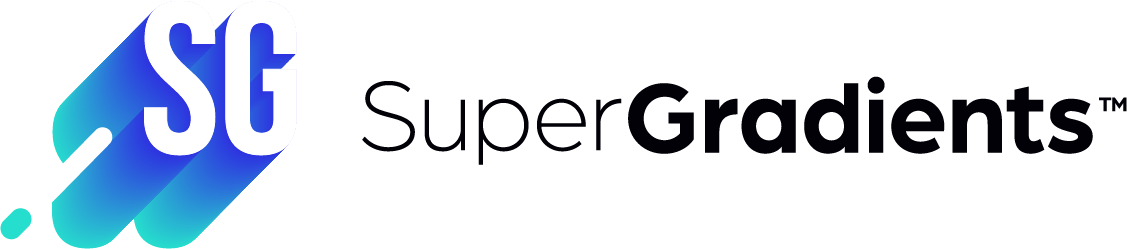

# SuperGradients quick start Semantic Segmentation

In this tutorial we will train PPLiteSeg model on Supervisely semantic segmentation dataset

The notebook is divided into 7 sections:
1. Experiment setup
2. Dataset definition
3. Architecture definition
4. Training setup
5. Training and Evaluation
6. Predict
7. Convert to ONNX\TensorRT

#Install SG

The cell below will install **super_gradients** which will automatically get all its dependencies.

In [1]:
! pip install -qq super-gradients==3.6.0

# 1. Experiment setup
We will initialize our **trainer** which will be in charge of everything, like training, evaluation, saving checkpoints, plotting etc.

The **experiment name** argument is important as every checkpoints, logs and tensorboards to be saved in a directory with the same name. This directory will be created as a sub-directory of **ckpt_root_dir** as follow:

```
ckpt_root_dir
|─── experiment_name_1
│       ckpt_best.pth                     # Model checkpoint on best epoch
│       ckpt_latest.pth                   # Model checkpoint on last epoch
│       average_model.pth                 # Model checkpoint averaged over epochs
│       events.out.tfevents.1659878383... # Tensorflow artifacts of a specific run
│       log_Aug07_11_52_48.txt            # Trainer logs of a specific run
└─── experiment_name_2
        ...
```
In this notebook multi-gpu training is set as `OFF`, for Distributed training multi_gpu can be set as
 `MultiGPUMode.DISTRIBUTED_DATA_PARALLEL` or `MultiGPUMode.DATA_PARALLEL`.

Let's define **ckpt_root_dir** inside the Colab, later we can use it to start TensorBoard and monitor the run.

In [2]:
from super_gradients import Trainer

CHECKPOINT_DIR = './notebook_ckpts/'
trainer = Trainer(experiment_name="segmentation_quick_start", ckpt_root_dir=CHECKPOINT_DIR)

The console stream is logged into /root/sg_logs/console.log


[2023-11-13 11:11:11] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-11-13 11:11:11] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-11-13 11:11:11] INFO - utils.py - NumExpr defaulting to 2 threads.
[2023-11-13 11:11:23] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-11-13 11:11:23] WARNING - export.py - Failed to import pytorch_quantization
[2023-11-13 11:11:23] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


# 2. Dataset definition



For the sake of this presentation, we'll use **Supervisely** semantic segmentation dataset.

SG trainer is fully compatible with PyTorch data loaders, so you can definitely use your own data for the experiment below if you prefer.

## 2.1 Download data


Feel free to change the download path by editing SUPERVISELY_DATASET_DOWNLOAD_PATH

In [3]:
import os

SUPERVISELY_DATASET_DOWNLOAD_PATH=os.path.join(os.getcwd(),"data")

supervisely_dataset_dir_path = os.path.join(SUPERVISELY_DATASET_DOWNLOAD_PATH, 'supervisely-persons')

if os.path.isdir(supervisely_dataset_dir_path):
    print('supervisely dataset already downloaded...')
else:
    print('Downloading and extracting supervisely dataset to: ' + SUPERVISELY_DATASET_DOWNLOAD_PATH)
    ! mkdir $SUPERVISELY_DATASET_DOWNLOAD_PATH
    %cd $SUPERVISELY_DATASET_DOWNLOAD_PATH
    ! wget https://deci-pretrained-models.s3.amazonaws.com/supervisely-persons.zip
    ! unzip --qq supervisely-persons.zip

## 2.2 Create data loaders


The dataloaders are initiated with the default parameters defined in the [yaml](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/dataset_params/supervisely_persons_dataset_params.yaml)
file. Parameters as batch_size, transforms, root_dir and others can be overridden by passing as `dataset_params` and
`dataloader_params`, as implemented bellow.

In [4]:
from super_gradients.training import dataloaders
root_dir = supervisely_dataset_dir_path
batch_size = 8

train_loader = dataloaders.supervisely_persons_train(dataset_params={"root_dir": root_dir}, dataloader_params={"batch_size": batch_size})
valid_loader = dataloaders.supervisely_persons_val(dataset_params={"root_dir": root_dir}, dataloader_params={"batch_size": batch_size})

supervisely dataset already downloaded...


As you can see, we didn't have to pass many parameters into the dataloaders construction. That's because defaults are pre-defined for your convenience, and you might be curious to know what they are. Let's print them and see which resolution and transformations are defined.

In [7]:
print('Dataloader parameters:')
print(train_loader.dataloader_params)
print('Dataset parameters')
print(train_loader.dataset.dataset_params)

Dataloader parameters:
{'batch_size': 8, 'shuffle': True, 'drop_last': True}
Dataset parameters
{'root_dir': '/content/data/supervisely-persons', 'list_file': 'train.csv', 'cache_labels': False, 'cache_images': False, 'transforms': [{'SegRandomRescale': {'scales': [0.25, 1.0]}}, {'SegColorJitter': {'brightness': 0.5, 'contrast': 0.5, 'saturation': 0.5}}, {'SegRandomFlip': {'prob': 0.5}}, {'SegPadShortToCropSize': {'crop_size': [320, 480], 'fill_mask': 0}}, {'SegCropImageAndMask': {'crop_size': [320, 480], 'mode': 'random'}}]}


# 3. Architecture definition



In [8]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

model = models.get(model_name=Models.PP_LITE_T_SEG,
                   arch_params={"use_aux_heads": False},
                   num_classes=1)

SG includes implementations of many different architectures for semantic segmentation tasks that can be found [here](https://github.com/Deci-AI/super-gradients#implemented-model-architectures).

Create a PPLiteSeg nn.Module, with 1 class segmentation head classifier. For simplicity `use_aux_head` is set as `False`
and extra Auxiliary heads aren't used for training.

Other segmentation modules can be used for this task such as, DDRNet, STDC and RegSeg.


# 4. Training setup





Here we define the training recipe. The full parameters can be found here  [training parameters supported](https://deci-ai.github.io/super-gradients/user_guide.html#training-parameters).

We will be using an average of BCE and Dice loss for segmentation, with different learning rates for the replaced segmentation head layer, and the rest of the network- this is controlled by the `multiply_head_lr` parameter which is the multiplication factor of the learning rate for the newly replaced layer.

As our `metric_to_watch`, we will be monitoring the `target_IOU` which is one of the components of `BinaryIOU` torchmetrics object (the other components are `mean_IOU` which is the mean of the background and target IOUs, and `background_IOU`).

In [10]:
from super_gradients.training.metrics.segmentation_metrics import BinaryIOU

train_params = {"max_epochs": 15,
                "lr_mode": "cosine",
                "initial_lr": 0.01,
                "lr_warmup_epochs": 5,
                "multiply_head_lr": 10,
                "optimizer": "SGD",
                "loss": "BCEDiceLoss",
                "ema": True,
                "ema_params":
                {
                "decay": 0.9999,
                "decay_type": "exp",
                "beta": 15,
                },

                "zero_weight_decay_on_bias_and_bn": True,
                "average_best_models": True,
                "metric_to_watch": "target_IOU",
                "greater_metric_to_watch_is_better": True,
                "train_metrics_list": [BinaryIOU()],
                "valid_metrics_list": [BinaryIOU()],
                "loss_logging_items_names": ["loss"]
                }

# 5. Training and evaluation


The logs and the checkpoint for the latest epoch will be kept in your experiment folder.

To start training we'll call train(...) and provide it with the objects we construted above: the model, the training parameters and the data loaders.


In [11]:
trainer.train(model=model, training_params=train_params, train_loader=train_loader, valid_loader=valid_loader)

[2023-11-13 11:15:07] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231113_111507_197271`
[2023-11-13 11:15:07] INFO - sg_trainer.py - Checkpoints directory: ./notebook_ckpts/segmentation_quick_start/RUN_20231113_111507_197271
[2023-11-13 11:15:07] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9999, 'decay_type': 'exp', 'beta': 15}


The console stream is now moved to ./notebook_ckpts/segmentation_quick_start/RUN_20231113_111507_197271/console_Nov13_11_15_07.txt


[2023-11-13 11:15:08] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            2477       (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         309        (len(train_loader))
    - Gradient updates per epoch:   309        (len(train_loader) / batch_accumulate)

[2023-11-13 11:15:08] INFO - sg_trainer.py - Started training for 15 epochs (0/14)

Validating: 100%|██████████| 65/65 [00:17<00:00,  3.69it/s]
[2023-11-13 11:17:39] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_quick_start/RUN_20231113_111507_197271/ckpt_best.pth
[202

SUMMARY OF EPOCH 0
├── Train
│   ├── Bcediceloss = 0.4001
│   ├── Target_iou = 0.6736
│   ├── Background_iou = 0.5448
│   └── Mean_iou = 0.6092
└── Validation
    ├── Bcediceloss = 0.4166
    ├── Target_iou = 0.6779
    ├── Background_iou = 0.4039
    └── Mean_iou = 0.5409



Validating epoch 1: 100%|██████████| 65/65 [00:17<00:00,  3.69it/s]
[2023-11-13 11:20:05] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_quick_start/RUN_20231113_111507_197271/ckpt_best.pth
[2023-11-13 11:20:05] INFO - sg_trainer.py - Best checkpoint overriden: validation target_IOU: 0.7205255031585693


SUMMARY OF EPOCH 1
├── Train
│   ├── Bcediceloss = 0.3381
│   │   ├── Epoch N-1      = 0.4001 (↘ -0.062)
│   │   └── Best until now = 0.4001 (↘ -0.062)
│   ├── Target_iou = 0.7193
│   │   ├── Epoch N-1      = 0.6736 (↗ 0.0457)
│   │   └── Best until now = 0.6736 (↗ 0.0457)
│   ├── Background_iou = 0.6036
│   │   ├── Epoch N-1      = 0.5448 (↗ 0.0587)
│   │   └── Best until now = 0.5448 (↗ 0.0587)
│   └── Mean_iou = 0.6614
│       ├── Epoch N-1      = 0.6092 (↗ 0.0522)
│       └── Best until now = 0.6092 (↗ 0.0522)
└── Validation
    ├── Bcediceloss = 0.3578
    │   ├── Epoch N-1      = 0.4166 (↘ -0.0588)
    │   └── Best until now = 0.4166 (↘ -0.0588)
    ├── Target_iou = 0.7205
    │   ├── Epoch N-1      = 0.6779 (↗ 0.0426)
    │   └── Best until now = 0.6779 (↗ 0.0426)
    ├── Background_iou = 0.4497
    │   ├── Epoch N-1      = 0.4039 (↗ 0.0458)
    │   └── Best until now = 0.4039 (↗ 0.0458)
    └── Mean_iou = 0.5851
        ├── Epoch N-1      = 0.5409 (↗ 0.0442)
        └── Best un

Validating epoch 2: 100%|██████████| 65/65 [00:16<00:00,  3.84it/s]
[2023-11-13 11:22:24] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_quick_start/RUN_20231113_111507_197271/ckpt_best.pth
[2023-11-13 11:22:24] INFO - sg_trainer.py - Best checkpoint overriden: validation target_IOU: 0.7300039529800415


SUMMARY OF EPOCH 2
├── Train
│   ├── Bcediceloss = 0.3199
│   │   ├── Epoch N-1      = 0.3381 (↘ -0.0182)
│   │   └── Best until now = 0.3381 (↘ -0.0182)
│   ├── Target_iou = 0.734
│   │   ├── Epoch N-1      = 0.7193 (↗ 0.0147)
│   │   └── Best until now = 0.7193 (↗ 0.0147)
│   ├── Background_iou = 0.6344
│   │   ├── Epoch N-1      = 0.6036 (↗ 0.0308)
│   │   └── Best until now = 0.6036 (↗ 0.0308)
│   └── Mean_iou = 0.6842
│       ├── Epoch N-1      = 0.6614 (↗ 0.0227)
│       └── Best until now = 0.6614 (↗ 0.0227)
└── Validation
    ├── Bcediceloss = 0.357
    │   ├── Epoch N-1      = 0.3578 (↘ -0.0008)
    │   └── Best until now = 0.3578 (↘ -0.0008)
    ├── Target_iou = 0.73
    │   ├── Epoch N-1      = 0.7205 (↗ 0.0095)
    │   └── Best until now = 0.7205 (↗ 0.0095)
    ├── Background_iou = 0.4503
    │   ├── Epoch N-1      = 0.4497 (↗ 0.0006)
    │   └── Best until now = 0.4497 (↗ 0.0006)
    └── Mean_iou = 0.5902
        ├── Epoch N-1      = 0.5851 (↗ 0.0051)
        └── Best unti

Validating epoch 3: 100%|██████████| 65/65 [00:16<00:00,  3.84it/s]
[2023-11-13 11:24:43] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_quick_start/RUN_20231113_111507_197271/ckpt_best.pth
[2023-11-13 11:24:43] INFO - sg_trainer.py - Best checkpoint overriden: validation target_IOU: 0.7432040572166443


SUMMARY OF EPOCH 3
├── Train
│   ├── Bcediceloss = 0.3022
│   │   ├── Epoch N-1      = 0.3199 (↘ -0.0177)
│   │   └── Best until now = 0.3199 (↘ -0.0177)
│   ├── Target_iou = 0.7501
│   │   ├── Epoch N-1      = 0.734  (↗ 0.0161)
│   │   └── Best until now = 0.734  (↗ 0.0161)
│   ├── Background_iou = 0.6447
│   │   ├── Epoch N-1      = 0.6344 (↗ 0.0103)
│   │   └── Best until now = 0.6344 (↗ 0.0103)
│   └── Mean_iou = 0.6974
│       ├── Epoch N-1      = 0.6842 (↗ 0.0132)
│       └── Best until now = 0.6842 (↗ 0.0132)
└── Validation
    ├── Bcediceloss = 0.3307
    │   ├── Epoch N-1      = 0.357  (↘ -0.0263)
    │   └── Best until now = 0.357  (↘ -0.0263)
    ├── Target_iou = 0.7432
    │   ├── Epoch N-1      = 0.73   (↗ 0.0132)
    │   └── Best until now = 0.73   (↗ 0.0132)
    ├── Background_iou = 0.4794
    │   ├── Epoch N-1      = 0.4503 (↗ 0.0291)
    │   └── Best until now = 0.4503 (↗ 0.0291)
    └── Mean_iou = 0.6113
        ├── Epoch N-1      = 0.5902 (↗ 0.0212)
        └── Best 

Validating epoch 4: 100%|██████████| 65/65 [00:17<00:00,  3.79it/s]
[2023-11-13 11:27:02] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_quick_start/RUN_20231113_111507_197271/ckpt_best.pth
[2023-11-13 11:27:02] INFO - sg_trainer.py - Best checkpoint overriden: validation target_IOU: 0.7445915341377258


SUMMARY OF EPOCH 4
├── Train
│   ├── Bcediceloss = 0.2867
│   │   ├── Epoch N-1      = 0.3022 (↘ -0.0155)
│   │   └── Best until now = 0.3022 (↘ -0.0155)
│   ├── Target_iou = 0.7604
│   │   ├── Epoch N-1      = 0.7501 (↗ 0.0103)
│   │   └── Best until now = 0.7501 (↗ 0.0103)
│   ├── Background_iou = 0.6697
│   │   ├── Epoch N-1      = 0.6447 (↗ 0.0251)
│   │   └── Best until now = 0.6447 (↗ 0.0251)
│   └── Mean_iou = 0.715
│       ├── Epoch N-1      = 0.6974 (↗ 0.0177)
│       └── Best until now = 0.6974 (↗ 0.0177)
└── Validation
    ├── Bcediceloss = 0.3281
    │   ├── Epoch N-1      = 0.3307 (↘ -0.0026)
    │   └── Best until now = 0.3307 (↘ -0.0026)
    ├── Target_iou = 0.7446
    │   ├── Epoch N-1      = 0.7432 (↗ 0.0014)
    │   └── Best until now = 0.7432 (↗ 0.0014)
    ├── Background_iou = 0.4869
    │   ├── Epoch N-1      = 0.4794 (↗ 0.0074)
    │   └── Best until now = 0.4794 (↗ 0.0074)
    └── Mean_iou = 0.6157
        ├── Epoch N-1      = 0.6113 (↗ 0.0044)
        └── Best u

Validating epoch 5: 100%|██████████| 65/65 [00:17<00:00,  3.75it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Bcediceloss = 0.2869
│   │   ├── Epoch N-1      = 0.2867 (↗ 1e-04)
│   │   └── Best until now = 0.2867 (↗ 1e-04)
│   ├── Target_iou = 0.7606
│   │   ├── Epoch N-1      = 0.7604 (↗ 0.0002)
│   │   └── Best until now = 0.7604 (↗ 0.0002)
│   ├── Background_iou = 0.6637
│   │   ├── Epoch N-1      = 0.6697 (↘ -0.0061)
│   │   └── Best until now = 0.6697 (↘ -0.0061)
│   └── Mean_iou = 0.7121
│       ├── Epoch N-1      = 0.715  (↘ -0.0029)
│       └── Best until now = 0.715  (↘ -0.0029)
└── Validation
    ├── Bcediceloss = 0.3339
    │   ├── Epoch N-1      = 0.3281 (↗ 0.0059)
    │   └── Best until now = 0.3281 (↗ 0.0059)
    ├── Target_iou = 0.7402
    │   ├── Epoch N-1      = 0.7446 (↘ -0.0044)
    │   └── Best until now = 0.7446 (↘ -0.0044)
    ├── Background_iou = 0.4593
    │   ├── Epoch N-1      = 0.4869 (↘ -0.0276)
    │   └── Best until now = 0.4869 (↘ -0.0276)
    └── Mean_iou = 0.5997
        ├── Epoch N-1      = 0.6157 (↘ -0.016)
        └── Bes

Validating epoch 6: 100%|██████████| 65/65 [00:17<00:00,  3.77it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Bcediceloss = 0.2686
│   │   ├── Epoch N-1      = 0.2869 (↘ -0.0183)
│   │   └── Best until now = 0.2867 (↘ -0.0181)
│   ├── Target_iou = 0.7721
│   │   ├── Epoch N-1      = 0.7606 (↗ 0.0115)
│   │   └── Best until now = 0.7606 (↗ 0.0115)
│   ├── Background_iou = 0.6892
│   │   ├── Epoch N-1      = 0.6637 (↗ 0.0255)
│   │   └── Best until now = 0.6697 (↗ 0.0194)
│   └── Mean_iou = 0.7306
│       ├── Epoch N-1      = 0.7121 (↗ 0.0185)
│       └── Best until now = 0.715  (↗ 0.0156)
└── Validation
    ├── Bcediceloss = 0.3278
    │   ├── Epoch N-1      = 0.3339 (↘ -0.0061)
    │   └── Best until now = 0.3281 (↘ -0.0003)
    ├── Target_iou = 0.7431
    │   ├── Epoch N-1      = 0.7402 (↗ 0.003)
    │   └── Best until now = 0.7446 (↘ -0.0015)
    ├── Background_iou = 0.4733
    │   ├── Epoch N-1      = 0.4593 (↗ 0.0139)
    │   └── Best until now = 0.4869 (↘ -0.0136)
    └── Mean_iou = 0.6082
        ├── Epoch N-1      = 0.5997 (↗ 0.0085)
        └── Best

Validating epoch 7: 100%|██████████| 65/65 [00:17<00:00,  3.77it/s]
[2023-11-13 11:34:05] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_quick_start/RUN_20231113_111507_197271/ckpt_best.pth
[2023-11-13 11:34:05] INFO - sg_trainer.py - Best checkpoint overriden: validation target_IOU: 0.7548585534095764


SUMMARY OF EPOCH 7
├── Train
│   ├── Bcediceloss = 0.259
│   │   ├── Epoch N-1      = 0.2686 (↘ -0.0096)
│   │   └── Best until now = 0.2686 (↘ -0.0096)
│   ├── Target_iou = 0.7808
│   │   ├── Epoch N-1      = 0.7721 (↗ 0.0087)
│   │   └── Best until now = 0.7721 (↗ 0.0087)
│   ├── Background_iou = 0.7009
│   │   ├── Epoch N-1      = 0.6892 (↗ 0.0117)
│   │   └── Best until now = 0.6892 (↗ 0.0117)
│   └── Mean_iou = 0.7409
│       ├── Epoch N-1      = 0.7306 (↗ 0.0102)
│       └── Best until now = 0.7306 (↗ 0.0102)
└── Validation
    ├── Bcediceloss = 0.3129
    │   ├── Epoch N-1      = 0.3278 (↘ -0.0149)
    │   └── Best until now = 0.3278 (↘ -0.0149)
    ├── Target_iou = 0.7549
    │   ├── Epoch N-1      = 0.7431 (↗ 0.0117)
    │   └── Best until now = 0.7446 (↗ 0.0103)
    ├── Background_iou = 0.5241
    │   ├── Epoch N-1      = 0.4733 (↗ 0.0508)
    │   └── Best until now = 0.4869 (↗ 0.0372)
    └── Mean_iou = 0.6395
        ├── Epoch N-1      = 0.6082 (↗ 0.0313)
        └── Best u

Validating epoch 8: 100%|██████████| 65/65 [00:17<00:00,  3.77it/s]
[2023-11-13 11:36:30] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_quick_start/RUN_20231113_111507_197271/ckpt_best.pth
[2023-11-13 11:36:30] INFO - sg_trainer.py - Best checkpoint overriden: validation target_IOU: 0.7585687637329102


SUMMARY OF EPOCH 8
├── Train
│   ├── Bcediceloss = 0.251
│   │   ├── Epoch N-1      = 0.259  (↘ -0.008)
│   │   └── Best until now = 0.259  (↘ -0.008)
│   ├── Target_iou = 0.786
│   │   ├── Epoch N-1      = 0.7808 (↗ 0.0052)
│   │   └── Best until now = 0.7808 (↗ 0.0052)
│   ├── Background_iou = 0.7125
│   │   ├── Epoch N-1      = 0.7009 (↗ 0.0116)
│   │   └── Best until now = 0.7009 (↗ 0.0116)
│   └── Mean_iou = 0.7493
│       ├── Epoch N-1      = 0.7409 (↗ 0.0084)
│       └── Best until now = 0.7409 (↗ 0.0084)
└── Validation
    ├── Bcediceloss = 0.3091
    │   ├── Epoch N-1      = 0.3129 (↘ -0.0039)
    │   └── Best until now = 0.3129 (↘ -0.0039)
    ├── Target_iou = 0.7586
    │   ├── Epoch N-1      = 0.7549 (↗ 0.0037)
    │   └── Best until now = 0.7549 (↗ 0.0037)
    ├── Background_iou = 0.5411
    │   ├── Epoch N-1      = 0.5241 (↗ 0.017)
    │   └── Best until now = 0.5241 (↗ 0.017)
    └── Mean_iou = 0.6498
        ├── Epoch N-1      = 0.6395 (↗ 0.0103)
        └── Best until 

Validating epoch 9: 100%|██████████| 65/65 [00:17<00:00,  3.72it/s]
[2023-11-13 11:38:53] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_quick_start/RUN_20231113_111507_197271/ckpt_best.pth
[2023-11-13 11:38:53] INFO - sg_trainer.py - Best checkpoint overriden: validation target_IOU: 0.759834885597229


SUMMARY OF EPOCH 9
├── Train
│   ├── Bcediceloss = 0.2465
│   │   ├── Epoch N-1      = 0.251  (↘ -0.0045)
│   │   └── Best until now = 0.251  (↘ -0.0045)
│   ├── Target_iou = 0.7905
│   │   ├── Epoch N-1      = 0.786  (↗ 0.0045)
│   │   └── Best until now = 0.786  (↗ 0.0045)
│   ├── Background_iou = 0.7133
│   │   ├── Epoch N-1      = 0.7125 (↗ 0.0008)
│   │   └── Best until now = 0.7125 (↗ 0.0008)
│   └── Mean_iou = 0.7519
│       ├── Epoch N-1      = 0.7493 (↗ 0.0026)
│       └── Best until now = 0.7493 (↗ 0.0026)
└── Validation
    ├── Bcediceloss = 0.3072
    │   ├── Epoch N-1      = 0.3091 (↘ -0.0018)
    │   └── Best until now = 0.3091 (↘ -0.0018)
    ├── Target_iou = 0.7598
    │   ├── Epoch N-1      = 0.7586 (↗ 0.0013)
    │   └── Best until now = 0.7586 (↗ 0.0013)
    ├── Background_iou = 0.5481
    │   ├── Epoch N-1      = 0.5411 (↗ 0.007)
    │   └── Best until now = 0.5411 (↗ 0.007)
    └── Mean_iou = 0.6539
        ├── Epoch N-1      = 0.6498 (↗ 0.0041)
        └── Best un

Validating epoch 10: 100%|██████████| 65/65 [00:17<00:00,  3.77it/s]
[2023-11-13 11:41:16] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_quick_start/RUN_20231113_111507_197271/ckpt_best.pth
[2023-11-13 11:41:16] INFO - sg_trainer.py - Best checkpoint overriden: validation target_IOU: 0.7605207562446594


SUMMARY OF EPOCH 10
├── Train
│   ├── Bcediceloss = 0.2399
│   │   ├── Epoch N-1      = 0.2465 (↘ -0.0066)
│   │   └── Best until now = 0.2465 (↘ -0.0066)
│   ├── Target_iou = 0.7956
│   │   ├── Epoch N-1      = 0.7905 (↗ 0.0051)
│   │   └── Best until now = 0.7905 (↗ 0.0051)
│   ├── Background_iou = 0.7229
│   │   ├── Epoch N-1      = 0.7133 (↗ 0.0096)
│   │   └── Best until now = 0.7133 (↗ 0.0096)
│   └── Mean_iou = 0.7593
│       ├── Epoch N-1      = 0.7519 (↗ 0.0074)
│       └── Best until now = 0.7519 (↗ 0.0074)
└── Validation
    ├── Bcediceloss = 0.3059
    │   ├── Epoch N-1      = 0.3072 (↘ -0.0014)
    │   └── Best until now = 0.3072 (↘ -0.0014)
    ├── Target_iou = 0.7605
    │   ├── Epoch N-1      = 0.7598 (↗ 0.0007)
    │   └── Best until now = 0.7598 (↗ 0.0007)
    ├── Background_iou = 0.5517
    │   ├── Epoch N-1      = 0.5481 (↗ 0.0037)
    │   └── Best until now = 0.5481 (↗ 0.0037)
    └── Mean_iou = 0.6561
        ├── Epoch N-1      = 0.6539 (↗ 0.0022)
        └── Best

Validating epoch 11: 100%|██████████| 65/65 [00:17<00:00,  3.76it/s]
[2023-11-13 11:43:37] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_quick_start/RUN_20231113_111507_197271/ckpt_best.pth
[2023-11-13 11:43:37] INFO - sg_trainer.py - Best checkpoint overriden: validation target_IOU: 0.7611058950424194


SUMMARY OF EPOCH 11
├── Train
│   ├── Bcediceloss = 0.2309
│   │   ├── Epoch N-1      = 0.2399 (↘ -0.009)
│   │   └── Best until now = 0.2399 (↘ -0.009)
│   ├── Target_iou = 0.8015
│   │   ├── Epoch N-1      = 0.7956 (↗ 0.0059)
│   │   └── Best until now = 0.7956 (↗ 0.0059)
│   ├── Background_iou = 0.7333
│   │   ├── Epoch N-1      = 0.7229 (↗ 0.0104)
│   │   └── Best until now = 0.7229 (↗ 0.0104)
│   └── Mean_iou = 0.7674
│       ├── Epoch N-1      = 0.7593 (↗ 0.0081)
│       └── Best until now = 0.7593 (↗ 0.0081)
└── Validation
    ├── Bcediceloss = 0.3046
    │   ├── Epoch N-1      = 0.3059 (↘ -0.0012)
    │   └── Best until now = 0.3059 (↘ -0.0012)
    ├── Target_iou = 0.7611
    │   ├── Epoch N-1      = 0.7605 (↗ 0.0006)
    │   └── Best until now = 0.7605 (↗ 0.0006)
    ├── Background_iou = 0.5546
    │   ├── Epoch N-1      = 0.5517 (↗ 0.0029)
    │   └── Best until now = 0.5517 (↗ 0.0029)
    └── Mean_iou = 0.6579
        ├── Epoch N-1      = 0.6561 (↗ 0.0017)
        └── Best u

Validating epoch 12: 100%|██████████| 65/65 [00:17<00:00,  3.77it/s]
[2023-11-13 11:46:00] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_quick_start/RUN_20231113_111507_197271/ckpt_best.pth
[2023-11-13 11:46:00] INFO - sg_trainer.py - Best checkpoint overriden: validation target_IOU: 0.7616798877716064


SUMMARY OF EPOCH 12
├── Train
│   ├── Bcediceloss = 0.2243
│   │   ├── Epoch N-1      = 0.2309 (↘ -0.0066)
│   │   └── Best until now = 0.2309 (↘ -0.0066)
│   ├── Target_iou = 0.8068
│   │   ├── Epoch N-1      = 0.8015 (↗ 0.0053)
│   │   └── Best until now = 0.8015 (↗ 0.0053)
│   ├── Background_iou = 0.736
│   │   ├── Epoch N-1      = 0.7333 (↗ 0.0027)
│   │   └── Best until now = 0.7333 (↗ 0.0027)
│   └── Mean_iou = 0.7714
│       ├── Epoch N-1      = 0.7674 (↗ 0.004)
│       └── Best until now = 0.7674 (↗ 0.004)
└── Validation
    ├── Bcediceloss = 0.3035
    │   ├── Epoch N-1      = 0.3046 (↘ -0.0012)
    │   └── Best until now = 0.3046 (↘ -0.0012)
    ├── Target_iou = 0.7617
    │   ├── Epoch N-1      = 0.7611 (↗ 0.0006)
    │   └── Best until now = 0.7611 (↗ 0.0006)
    ├── Background_iou = 0.5569
    │   ├── Epoch N-1      = 0.5546 (↗ 0.0023)
    │   └── Best until now = 0.5546 (↗ 0.0023)
    └── Mean_iou = 0.6593
        ├── Epoch N-1      = 0.6579 (↗ 0.0014)
        └── Best un

Validating epoch 13: 100%|██████████| 65/65 [00:17<00:00,  3.81it/s]
[2023-11-13 11:48:23] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_quick_start/RUN_20231113_111507_197271/ckpt_best.pth
[2023-11-13 11:48:23] INFO - sg_trainer.py - Best checkpoint overriden: validation target_IOU: 0.7624021172523499


SUMMARY OF EPOCH 13
├── Train
│   ├── Bcediceloss = 0.2194
│   │   ├── Epoch N-1      = 0.2243 (↘ -0.0049)
│   │   └── Best until now = 0.2243 (↘ -0.0049)
│   ├── Target_iou = 0.8097
│   │   ├── Epoch N-1      = 0.8068 (↗ 0.0029)
│   │   └── Best until now = 0.8068 (↗ 0.0029)
│   ├── Background_iou = 0.7447
│   │   ├── Epoch N-1      = 0.736  (↗ 0.0086)
│   │   └── Best until now = 0.736  (↗ 0.0086)
│   └── Mean_iou = 0.7772
│       ├── Epoch N-1      = 0.7714 (↗ 0.0058)
│       └── Best until now = 0.7714 (↗ 0.0058)
└── Validation
    ├── Bcediceloss = 0.3024
    │   ├── Epoch N-1      = 0.3035 (↘ -0.0011)
    │   └── Best until now = 0.3035 (↘ -0.0011)
    ├── Target_iou = 0.7624
    │   ├── Epoch N-1      = 0.7617 (↗ 0.0007)
    │   └── Best until now = 0.7617 (↗ 0.0007)
    ├── Background_iou = 0.5596
    │   ├── Epoch N-1      = 0.5569 (↗ 0.0027)
    │   └── Best until now = 0.5569 (↗ 0.0027)
    └── Mean_iou = 0.661
        ├── Epoch N-1      = 0.6593 (↗ 0.0017)
        └── Best 

Validating epoch 14: 100%|██████████| 65/65 [00:17<00:00,  3.78it/s]
[2023-11-13 11:50:45] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_quick_start/RUN_20231113_111507_197271/ckpt_best.pth
[2023-11-13 11:50:45] INFO - sg_trainer.py - Best checkpoint overriden: validation target_IOU: 0.763008713722229


SUMMARY OF EPOCH 14
├── Train
│   ├── Bcediceloss = 0.2155
│   │   ├── Epoch N-1      = 0.2194 (↘ -0.0039)
│   │   └── Best until now = 0.2194 (↘ -0.0039)
│   ├── Target_iou = 0.8134
│   │   ├── Epoch N-1      = 0.8097 (↗ 0.0037)
│   │   └── Best until now = 0.8097 (↗ 0.0037)
│   ├── Background_iou = 0.7484
│   │   ├── Epoch N-1      = 0.7447 (↗ 0.0038)
│   │   └── Best until now = 0.7447 (↗ 0.0038)
│   └── Mean_iou = 0.7809
│       ├── Epoch N-1      = 0.7772 (↗ 0.0037)
│       └── Best until now = 0.7772 (↗ 0.0037)
└── Validation
    ├── Bcediceloss = 0.3015
    │   ├── Epoch N-1      = 0.3024 (↘ -0.0009)
    │   └── Best until now = 0.3024 (↘ -0.0009)
    ├── Target_iou = 0.763
    │   ├── Epoch N-1      = 0.7624 (↗ 0.0006)
    │   └── Best until now = 0.7624 (↗ 0.0006)
    ├── Background_iou = 0.5621
    │   ├── Epoch N-1      = 0.5596 (↗ 0.0025)
    │   └── Best until now = 0.5596 (↗ 0.0025)
    └── Mean_iou = 0.6625
        ├── Epoch N-1      = 0.661  (↗ 0.0016)
        └── Best 

[2023-11-13 11:50:47] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 15:  98%|█████████▊| 64/65 [00:16<00:00,  3.27it/s]

In [12]:
print("Best Checkpoint mIoU is: "+ str(trainer.best_metric))

Best Checkpoint mIoU is: 0.763008713722229


Now you can download your trained weights from this directory

In [13]:
print(trainer.checkpoints_dir_path)

# 6. Predict


When the training is complete you can use the trained model to get predictions on the validation set, your data or some other image. Let's load some image and
run a model inference to create a binary segmentation mask.

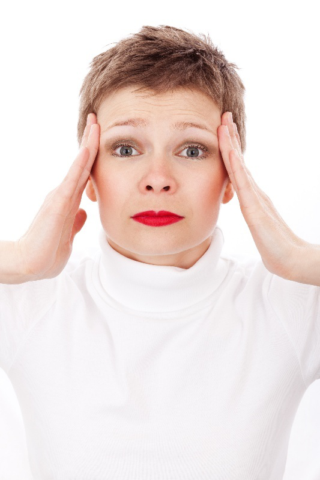

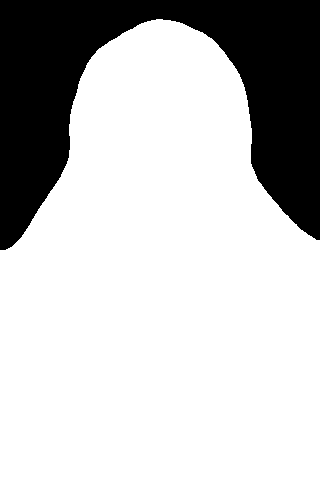

In [17]:
from torchvision.transforms import Compose, ToTensor, Resize, Normalize, ToPILImage
from PIL import Image
import torch

pre_proccess = Compose([
    ToTensor(),
    Normalize([.485, .456, .406], [.229, .224, .225])
])

demo_img_path = os.path.join(root_dir, "images", "ache-adult-depression-expression-41253.png")
img = Image.open(demo_img_path)
# Resize the image and display
img = Resize(size=(480, 320))(img)
display(img)

# Run pre-proccess - transforms to tensor and apply normalizations.
img = pre_proccess(img).unsqueeze(0).cuda()

# Run inference
model = trainer.net
model = model.eval()
mask = model(img)

# Run post-proccess - apply sigmoid to output probabilities, then apply hard
# threshold of 0.5 for binary mask prediction.
mask = torch.sigmoid(mask).gt(0.5).squeeze()
mask = ToPILImage()(mask.float())
display(mask)


# 7. Convert to ONNX/TensorRT

Let's compile our model to ONNX.

In [22]:
from onnxsim import simplify
import onnx

onnx_path = os.path.join(os.getcwd(), "model.onnx")

input_size = [1, 3, 480, 320]
model.prep_model_for_conversion(input_size=input_size)

torch.onnx.export(model,
                  torch.randn(*input_size).cuda(),
                  onnx_path)

# onnx simplifier
model_sim, check = simplify(onnx_path)
assert check, "Simplified ONNX model could not be validated"
onnx.save_model(model_sim, onnx_path)

print("ONNX successfully created at: ", onnx_path)



ONNX successfully created at:  /content/model.onnx
